# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2020-05-08 05:46:59,880 INFO    : root         : Using LISA logging configuration:
2020-05-08 05:46:59,881 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2020-05-08 05:47:00,250 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2020-05-08 05:47:00,272 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnMUFaRUYvMUFaRUZTSTZfUE9TXzE5MTAxMF8xOTEwMTBfMTkyOTAyX2NvbnRhY3QnLCBsYXlvdXQ9TGHigKY=


## Run cells

Please select over systrace files and press the run button to execute below cells.

In [11]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [12]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select some systraces to analysis.

## Read Files

In [13]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing 1ZAEFSLC_QOStest_200204_200204_101354_message.html - 128452 lines are Ok
Parsing 1ZAEFSLC_QOStest_200204_200204_103633_message.html - 126368 lines are Ok
Parsing 1ZAEFSLC_QOStest_200204_200204_105858_message.html - 129004 lines are Ok
Parsing 1ZAEVTAC_QOStest_200204_200204_105858_message.html - 190038 lines are Ok
Parsing 1ZAEVTAC_QOStest_200204_200204_103633_message.html - 189636 lines are Ok
Parsing 1ZAEVTAC_QOStest_200204_200204_101355_message.html - 187536 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters.

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12192.0,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,788.533
2436.0,NaN,3.894,2.116,NaN,NaN,NaN,NaN,NaN
1487.0,NaN,0.953,47.251,NaN,NaN,NaN,NaN,NaN
1488.0,NaN,8.092,0.861,NaN,NaN,NaN,NaN,NaN
12593.0,NaN,93.412,8.024,242.151,292.423,31.891,18.717,NaN
12659.0,NaN,NaN,NaN,161.964,NaN,12.054,NaN,NaN
3510.0,1.531,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2490.0,0.347,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
3524.0,2.089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12360.0,NaN,94.878,6.798,279.620,339.334,19.468,20.343,NaN
11977.0,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2508.0,0.324,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2445.0,NaN,1.856,2.010,NaN,NaN,NaN,NaN,NaN
12429.0,NaN,NaN,NaN,194.252,NaN,12.278,NaN,NaN
1448.0,NaN,0.921,39.412,NaN,NaN,NaN,NaN,NaN
1394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,850.116
12406.0,29.549,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1376.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.456
12352.0,NaN,103.458,7.131,208.008,302.425,16.969,17.321,NaN
1475.0,NaN,1.061,38.457,NaN,NaN,NaN,NaN,NaN
1477.0,NaN,2.592,0.815,NaN,NaN,NaN,NaN,NaN
12394.0,30.739,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2541.0,1.263,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2447.0,NaN,3.519,3.737,NaN,NaN,NaN,NaN,NaN
3474.0,1.446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12419.0,NaN,NaN,NaN,169.547,NaN,14.054,NaN,NaN


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
11457.0,NaN,NaN,NaN,416.290,NaN,8.292,NaN,NaN
1383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,833.575
1448.0,NaN,0.837,24.586,NaN,NaN,NaN,NaN,NaN
1449.0,NaN,2.224,0.555,NaN,NaN,NaN,NaN,NaN
2411.0,0.307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1932.0,NaN,26.988,6.355,NaN,NaN,NaN,NaN,NaN
3406.0,1.529,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11375.0,NaN,114.338,9.410,338.485,234.195,21.013,21.211,NaN
11438.0,NaN,NaN,NaN,308.919,NaN,17.102,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
11472.0,NaN,NaN,NaN,273.840,NaN,11.948,NaN,NaN
1923.0,NaN,24.611,7.292,NaN,NaN,NaN,NaN,NaN
11493.0,NaN,NaN,NaN,383.587,NaN,8.095,NaN,NaN
2406.0,0.318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,802.345
1456.0,NaN,0.975,34.928,NaN,NaN,NaN,NaN,NaN
11409.0,NaN,113.074,8.621,315.847,222.192,18.337,21.114,NaN
2326.0,NaN,4.018,4.030,NaN,NaN,NaN,NaN,NaN
1457.0,NaN,4.633,1.014,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
3398.0,1.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11271.0,NaN,NaN,NaN,282.717,NaN,10.678,NaN,NaN
11208.0,NaN,120.933,11.574,359.354,245.181,19.303,23.732,NaN
1930.0,NaN,26.152,12.145,NaN,NaN,NaN,NaN,NaN
1388.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,881.07
2446.0,0.338,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11248.0,32.460,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461.0,NaN,1.021,30.506,NaN,NaN,NaN,NaN,NaN
1462.0,NaN,2.125,0.527,NaN,NaN,NaN,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [17]:
list_of_df = group1.get_marking_time()
sum_df1 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1) * 1000
    sum_df1.loc['mean'] = sum_df1.mean()
except:
    print("No launching time")
    
list_of_df = group2.get_marking_time()
sum_df2 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1) * 1000
    sum_df2.loc['mean'] = sum_df2.mean()
except:
    print("No launching time")

In [18]:
display(pd.concat([sum_df1, sum_df2], keys=[group1.title, group2.title], sort=False))

launching
                                                   pid               
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message 1410.0  788.533000
                                                   1394.0  850.116000
                                                   1376.0  741.456000
                                                   mean    793.368333
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message 1383.0  833.575000
                                                   1383.0  802.345000
                                                   1388.0  881.070000

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [19]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [20]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                               time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                              Choreographer #0  \
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message time                                 97.249   
                                                   RUNNING                              39.014   
                                                   RUNNABLE                              1.880   
                                                   SLEEPING                             47.866   
                                                   UNINTERUPTIBLE_SLEEP                  0.068   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             8.421   
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message time                                116.115   
                                                   RUNNING                              71.998   
                                                   RUNNABLE                              2.111   
                                                   SLEEPING                             38.439   
                                                   UNINTERUPTIBLE_SLEEP                  0.050   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             3.517   
DIFF                                               time                                -18.866   
                                                   RUNNING                             -32.984   
                                                   RUNNABLE                             -0.231   
                                                   SLEEPING                              9.427   
                                                   UNINTERUPTIBLE_SLEEP                  0.018   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             4.904   

                                                                              Choreographer #1  \
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message time                                  7.318   
                                                   RUNNING                               1.280   
                                                   RUNNABLE                              0.089   
                                                   SLEEPING               

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message,time,0,97.249,7.318,243.260,311.394,22.776,18.794,0
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message,time,0,116.115,9.868,337.895,233.856,19.551,22.019,0
DIFF,time,0,-18.866,-2.550,-94.635,77.538,3.225,-3.225,0


### Processing time of setSurface

In [21]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [22]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,2,3,avg
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message,27.190,29.549,30.739,29.159333
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message,33.136,33.808,32.460,33.134667


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [23]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_madvise+0x1cc/0x258,0.000000,0.0,0.000000,0.333333,0.0,0.000000
uninter_reason//SyS_munmap+0x30/0x6c,0.000000,0.0,0.000000,0.333333,0.0,0.000000
uninter_reason//SyS_prctl+0x368/0x8a8,0.000000,0.0,3.000000,0.666667,0.0,0.000000
uninter_reason//__fdget_pos+0x40/0x50,0.000000,0.0,1.000000,0.000000,0.0,0.000000
uninter_reason//__vma_adjust+0x144/0x690,0.000000,0.0,0.000000,0.333333,0.0,0.000000
uninter_reason//do_mprotect_pkey+0x98/0x22c,0.000000,0.0,3.666667,3.333333,0.0,0.000000
uninter_reason//do_page_fault+0x22c/0x488,3.666667,0.0,16.666667,8.666667,0.0,0.666667
uninter_reason//expand_files+0x1ec/0x230,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//vm_mmap_pgoff+0xa4/0xf4,0.000000,0.0,5.666667,2.333333,0.0,0.000000
uninter_reason_io//__lock_page_killable+0x138/0x1fc,5.333333,0.0,0.000000,58.666667,0.0,2.333333


1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_madvise+0x1cc/0x258,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//SyS_munmap+0x30/0x6c,0.000000,0.0,0.000000,0.333333,0.0,0.000000
uninter_reason//SyS_prctl+0x368/0x8a8,0.000000,0.0,2.000000,0.666667,0.0,0.000000
uninter_reason//__fdget_pos+0x40/0x50,0.000000,0.0,0.333333,0.000000,0.0,0.333333
uninter_reason//__vma_adjust+0x144/0x690,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//do_mprotect_pkey+0x98/0x22c,0.000000,0.0,3.333333,2.000000,0.0,0.000000
uninter_reason//do_page_fault+0x22c/0x488,2.666667,0.0,18.333333,14.000000,0.0,0.000000
uninter_reason//expand_files+0x1ec/0x230,0.000000,0.0,0.000000,0.666667,0.0,0.000000
uninter_reason//vm_mmap_pgoff+0xa4/0xf4,0.000000,0.0,2.333333,3.666667,0.0,0.000000
uninter_reason_io//__lock_page_killable+0x138/0x1fc,4.333333,0.0,151.666667,39.666667,0.0,1.000000


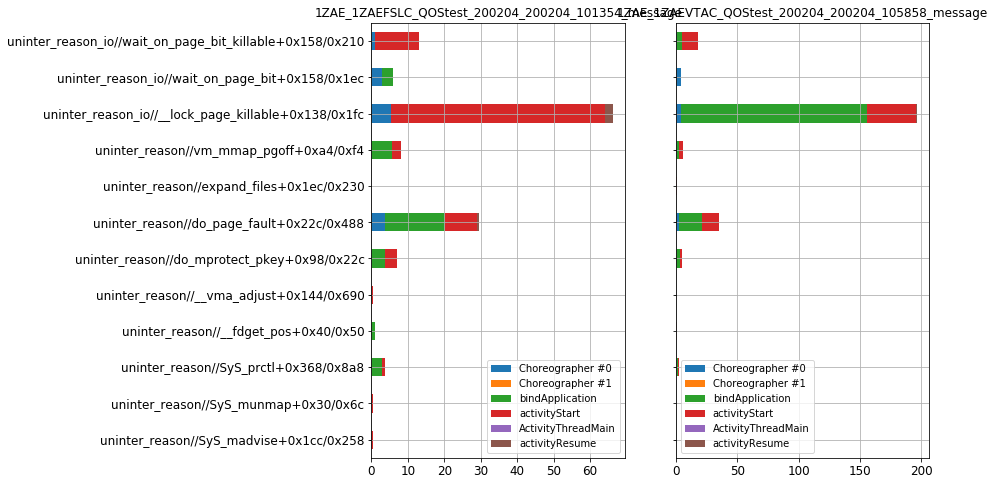

In [24]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)

print(group1.title)
display(df1)
print(group2.title)
display(df2)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

The number of count in each reason of uninterruptible sleep.

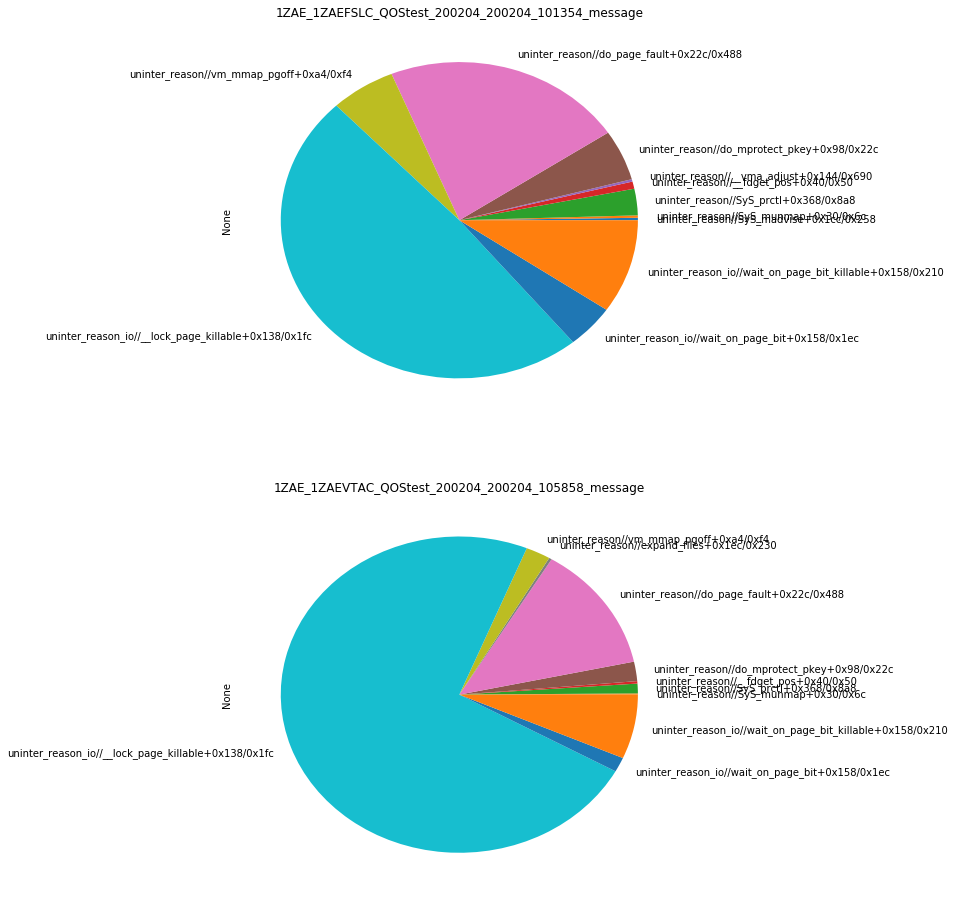

In [25]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

In [26]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)

In [27]:
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

Choreographer #0  \
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message core0                24   
                                                   core1                21   
                                                   core2                37   
                                                   core3                10   
                                                   core4                 0   
                                                   core5                 0   
                                                   core6                 0   
                                                   core7                 0   
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message core0                10   
                                                   core1                35   
                                                   core2                26   
                                                   core3                21   
                                                   core4                 0   
                                                   core5                 0   
                                                   core6                 0   
                                                   core7                 0   

                                                          Choreographer #1  \
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message core0                 2   
                                                   core1                 1   
                                                   core2                 2   
                                                   core3                 4   
                                                   core4                 1   
                                                   core5                 0   
                                                   core6                 0   
                                                   core7                 0   
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message core0                 9   
                                                   core1                 0   
                                                   core2                10   
                                                   core3                 0   
                                                   core4                 0   
                                                   core5                 0   
                                                   core6                 0   
                                                   core7                 0   

                                                          bindApplication  \
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message core0               94   
                                                   core1               74   
                                                   core2               64   
                                                   core3               94   
                                                   core4               23   
                                                   core5               20   
                                                   core6                8   
                                                   core7               13   
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message core0              206   
                                                   core1              212   
                                                   core2              213   
                                                   core3              212   
                                                   core4               28   
                                                   core5               12   
                                                   core6                8   
                                                   core7                8   

                                                          activityStart  \
1ZAE_1ZAEFSLC_QOSte

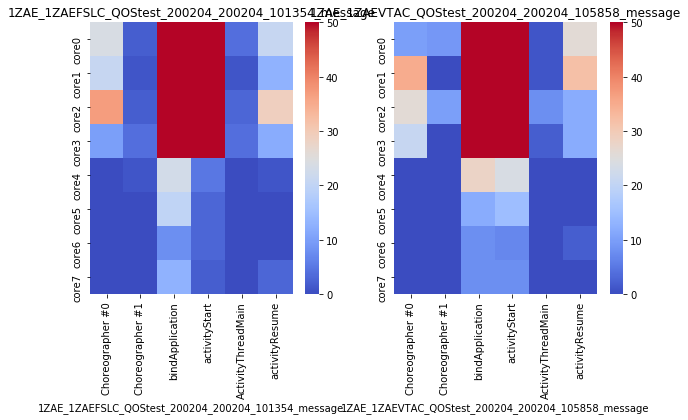

In [28]:
plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [29]:
print(group1.title)
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,3,0,45,65,0,10,NaN
core1,NaN,10,1,7,61,0,3,NaN
core2,NaN,16,2,35,29,0,10,NaN
core3,NaN,5,0,42,49,4,0,NaN
core4,NaN,0,0,9,2,0,1,NaN
core5,NaN,0,0,8,1,0,0,NaN
core6,NaN,0,0,2,2,0,0,NaN
core7,NaN,0,0,5,0,0,3,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,12,1,30,44,0,7,NaN
core1,NaN,6,0,40,70,1,5,NaN
core2,NaN,10,0,8,44,3,6,NaN
core3,NaN,2,2,25,49,0,11,NaN
core4,NaN,0,0,9,1,0,0,NaN
core5,NaN,0,0,11,1,0,0,NaN
core6,NaN,0,0,4,0,0,0,NaN
core7,NaN,0,0,7,1,0,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,9,1,19,57,4,4,NaN
core1,NaN,5,0,27,53,0,5,NaN
core2,NaN,11,0,21,42,0,13,NaN
core3,NaN,3,2,27,47,0,1,NaN
core4,NaN,0,1,5,2,0,0,NaN
core5,NaN,0,0,1,1,0,0,NaN
core6,NaN,0,0,2,1,0,0,NaN
core7,NaN,0,0,1,1,0,0,NaN


In [50]:
print(group2.title)
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,3,0,73,47,0,10,NaN
core1,NaN,17,0,65,47,1,4,NaN
core2,NaN,2,6,58,38,2,8,NaN
core3,NaN,9,0,87,51,1,3,NaN
core4,NaN,0,0,4,7,0,0,NaN
core5,NaN,0,0,2,5,0,0,NaN
core6,NaN,0,0,2,5,0,2,NaN
core7,NaN,0,0,2,3,0,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,1,3,68,54,1,7,NaN
core1,NaN,3,0,69,33,0,9,NaN
core2,NaN,12,2,80,59,3,4,NaN
core3,NaN,6,0,55,57,0,0,NaN
core4,NaN,0,0,11,6,0,0,NaN
core5,NaN,0,0,5,2,0,0,NaN
core6,NaN,0,0,4,0,0,0,NaN
core7,NaN,0,0,6,3,0,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,6,6,65,32,0,9,NaN
core1,NaN,15,0,78,64,0,19,NaN
core2,NaN,12,2,75,44,3,0,NaN
core3,NaN,6,0,70,33,1,9,NaN
core4,NaN,0,0,13,11,0,0,NaN
core5,NaN,0,0,5,8,0,0,NaN
core6,NaN,0,0,2,2,0,0,NaN
core7,NaN,0,0,0,2,0,0,NaN


In [31]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [51]:
print(group1.title)
display(GetCoreStats(group1))

1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    V  I  R  I  I  I  I  I         0  332.536929
                   1    V  I  I  I  I  I  I  I         0  332.537501
                   2    V  I  I  I  I  I  I  I         0  332.545747
                   3    R  I  I  V  I  I  I  I         3  332.551935
bindApplication    0    I  I  R  V  I  I  I  I         3  332.553157
                   1    I  I  V  I  I  I  I  I         2  332.553257
                   2    I  I  R  V  I  I  I  I         3  332.553416
                   3    I  V  I  I  I  I  I  I         1  332.553986
                   4    I  I  I  V  I  I  I  I         3  332.554085
                   5    I  I  I  V  I  I  I  I         3  332.554330
                   6    I  I  I  V  I  I  I  I         3  332.561655
                   7    R  I  I  V  I  I  I  I         3  332.562030
                   8    V  I  I  R  I  I  I  I         0  332.564718
                   9    V  I  I  I  I  I  I  I         0  332.565124
                   10   V  R  I  R  I  I  I  I         0  332.600096
                   11   V  R  I  I  I  I  I  I         0  332.603622
                   12   V  I  R  I  I  I  I  I         0  332.608702
                   13   I  I  V  I  I  I  I  I         2  332.612169
                   14   V  R  I  I  I  I  I  I         0  332.612273
                   15   V  I  I  I  I  I  I  I         0  332.613159
                   16   V  R  I  I  I  I  I  I         0  332.613487
                   17   I  V  I  I  I  I  I  I         1  332.613628
                   18   V  I  I  I  I  I  I  I         0  332.613985
                   19   I  V  I  I  I  I  I  I         1  332.614859
                   20   V  I  I  I  I  I  I  I         0  332.614908
                   21   I  V  R  I  I  I  I  I         1  332.616354
                   22   V  R  I  I  I  I  I  I         0  332.617870
                   23   V  R  I  I  I  I  I  I         0  332.618158
                   24   V  R  I  R  I  I  I  I         0  332.618392
                   25   I  V  I  I  I  I  I  I         1  332.619342
                   26   I  I  I  V  I  I  I  I         3  332.619876
                   27   I  I  I  V  R  I  I  I         3  332.620137
                   28   I  I  I  V  I  I  I  I         3  332.620357
                   29   I  V  I  I  I  I  I  I         1  332.620827
                   30   I  V  I  I  I  I  I  I         1  332.621246
                   31   I  I  I  V  I  I  I  I         3  332.621715
                   32   I  V  I  R  I  I  I  I         1  332.622403
                   33   I  R  V  I  I  I  I  I         2  332.630098
                   34   I  I  V  R  I  I  I  I         2  332.632572
                   35   R  V  I  I  I  I  I  I         1  332.644409
                   36   R  V  I  I  I  I  I  I         1  332.644494
                   37   R  V  I  I  I  I  I  I         1  332.647366
                   38   R  V  I  I  I  I  I  I         1  332.648046
                   39   R  I  V  I  I  I  I  I         2  332.648349
                   40   R  V  I  I  I  I  I  I         1  332.648406
                   41   R  I  V  I  I  I  I  I         2  332.648543
                   42   R  V  I  I  I  I  I  I         1  332.648693
                   43   R  I  V  R  I  I  I  I         2  332.649194
                   44   R  V  R  R  I  I  I  I         1  332.649261
                   45   I  V  I  I  I  I  I  I         1  332.649439
                   46   R  R  I  I  V  I  I  I         4  332.660096
                   47   R  R  V  I  R  I  I  I         2  332.660199
                   48   R  V  I  I  I  I  I  I         1  332.661638
                   49   I  V  I  I  I  I  I  I         1  332.664730
                   50   I  V  I  I  I  I  I  I         1  332.665222
                   51   R  V  I  I  I  I  I  I         1  332.665449
                   52   V  I  R  I  I  I  I  I         0  332.667425
                   53 

In [52]:
print(group2.title)
display(GetCoreStats(group2))

1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  I  V  I  I  I  I  I         2  331.703693
                   1    I  I  V  I  I  I  I  I         2  331.704277
                   2    I  I  I  V  I  I  I  R         3  331.705227
                   3    R  I  R  V  I  I  I  I         3  331.721265
bindApplication    0    R  I  I  V  I  I  I  I         3  331.722415
                   1    R  I  I  V  I  I  I  I         3  331.722661
                   2    I  I  I  V  I  I  I  I         3  331.724124
                   3    I  I  I  V  I  I  I  I         3  331.724623
                   4    I  I  I  I  V  I  I  I         4  331.726677
                   5    R  R  I  I  V  I  I  I         4  331.727991
                   6    R  R  I  V  I  I  I  I         3  331.728338
                   7    I  I  I  V  I  I  I  I         3  331.728817
                   8    I  I  I  V  I  I  I  I         3  331.733024
                   9    I  I  I  V  I  I  I  I         3  331.738007
                   10   V  I  R  I  I  I  I  I         0  331.749600
                   11   R  I  V  I  I  I  I  I         2  331.751166
                   12   I  I  V  R  I  I  I  I         2  331.754252
                   13   I  I  V  I  I  I  I  R         2  331.754695
                   14   I  V  I  I  I  I  R  I         1  331.754818
                   15   I  I  I  I  V  I  I  I         4  331.757914
                   16   R  V  R  I  I  I  I  I         1  331.758693
                   17   R  V  I  I  I  I  I  I         1  331.761485
                   18   I  I  I  V  I  I  I  I         3  331.762954
                   19   I  I  I  V  R  I  I  I         3  331.764237
                   20   I  I  I  V  I  I  I  I         3  331.770149
                   21   I  R  R  V  I  I  I  I         3  331.770354
                   22   V  I  I  I  I  I  I  I         0  331.770886
                   23   V  I  I  R  R  I  I  I         0  331.771373
                   24   V  I  I  R  R  I  I  I         0  331.772193
                   25   I  I  I  R  R  V  I  I         5  331.772368
                   26   V  I  R  I  I  R  I  I         0  331.773610
                   27   V  I  R  I  I  I  I  I         0  331.773665
                   28   R  I  V  I  I  I  I  I         2  331.774737
                   29   V  I  I  I  I  I  I  I         0  331.775227
                   30   V  I  I  I  I  I  I  I         0  331.775300
                   31   I  I  V  R  I  I  I  I         2  331.775426
                   32   I  I  V  R  I  I  I  I         2  331.775457
                   33   I  I  V  R  I  I  I  I         2  331.775535
                   34   I  I  V  I  I  I  I  I         2  331.777343
                   35   V  I  I  I  I  I  I  I         0  331.780415
                   36   I  I  V  I  I  I  I  I         2  331.780496
                   37   I  I  V  I  I  I  I  I         2  331.781581
                   38   I  I  V  I  I  I  I  I         2  331.781960
                   39   I  R  V  I  I  I  I  I         2  331.782500
                   40   I  I  I  V  I  I  I  I         3  331.783603
                   41   I  I  V  I  I  I  I  I         2  331.783705
                   42   I  I  I  V  I  I  I  I         3  331.785205
                   43   I  I  V  I  I  I  I  I         2  331.785643
                   44   V  I  I  R  I  I  I  I         0  331.785793
                   45   I  I  V  I  I  I  I  I         2  331.785884
                   46   R  I  V  I  I  I  I  I         2  331.786113
                   47   I  I  V  I  I  I  I  I         2  331.786260
                   48   I  I  V  I  I  I  I  I         2  331.786448
                   49   I  I  V  I  I  I  I  I         2  331.786542
                   50   V  I  I  R  I  I  I  I         0  331.787046
                   51   V  I  I  I  I  I  I  I         0  331.787465
                   52   I  I  V  R  I  I  I  I         2  331.788065
                   53 

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [34]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

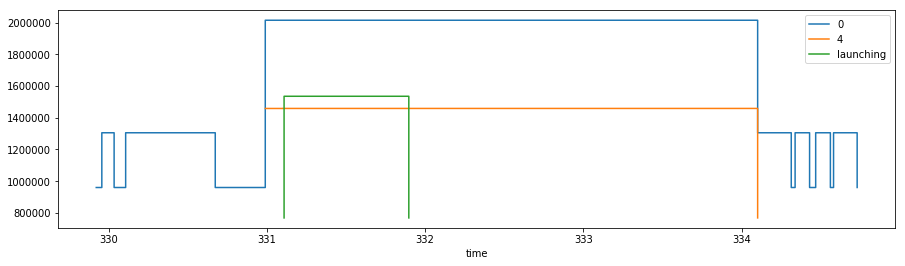

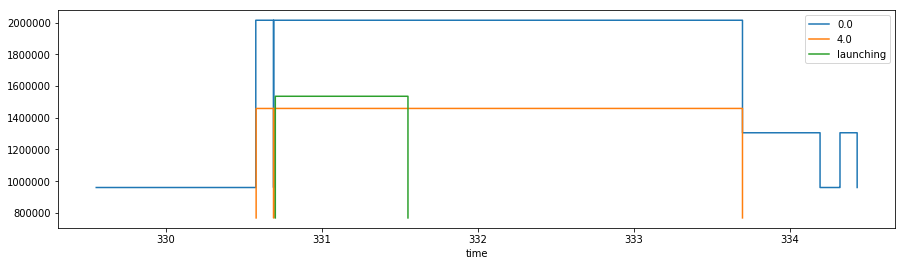

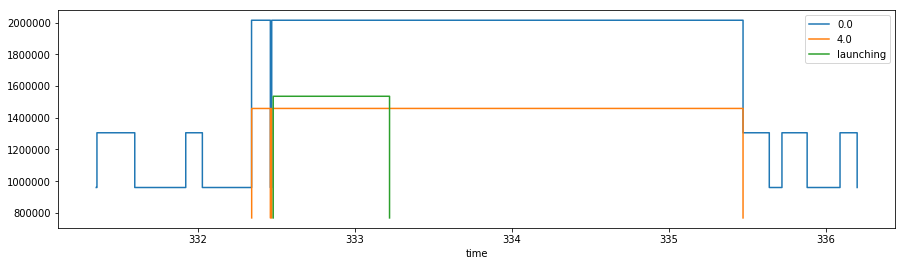

In [35]:
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

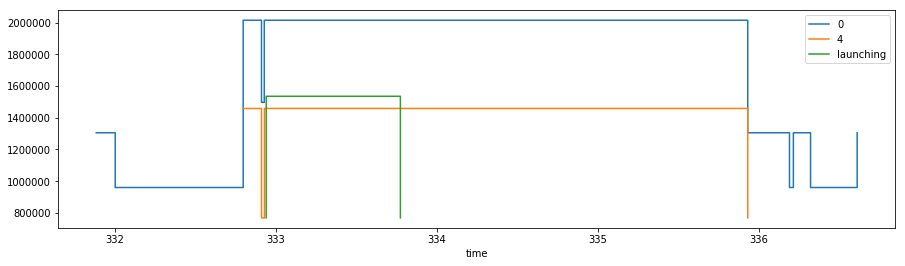

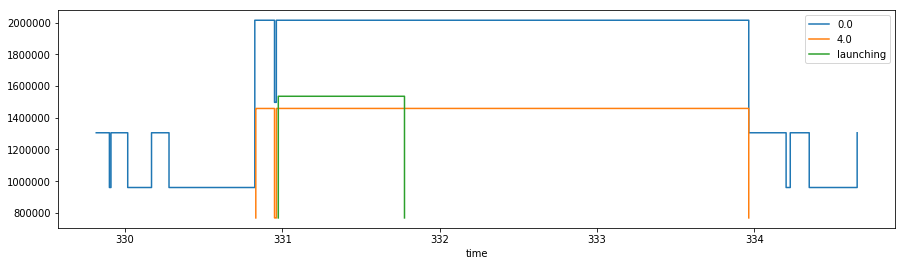

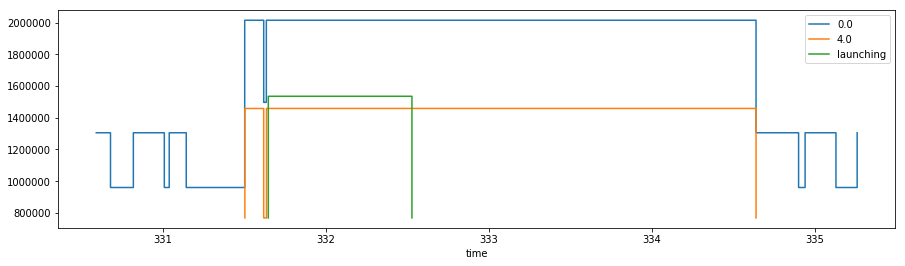

In [36]:
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [37]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

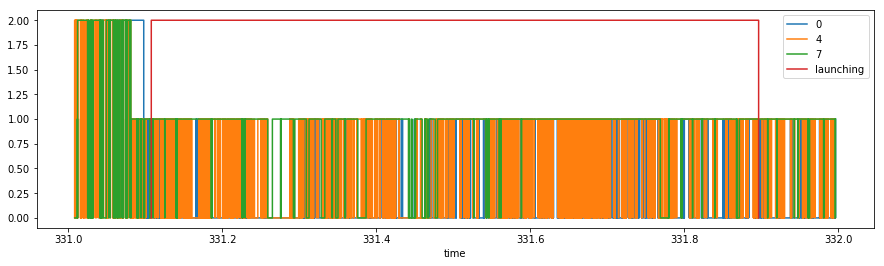

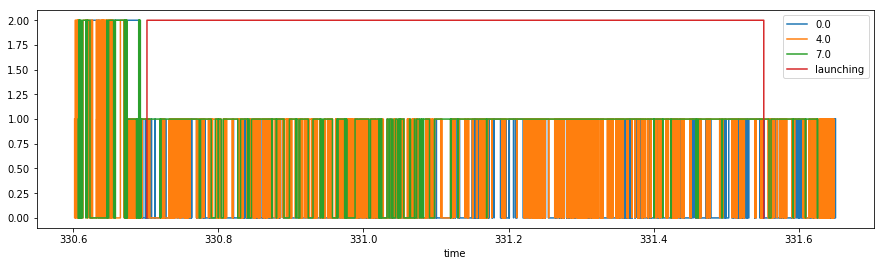

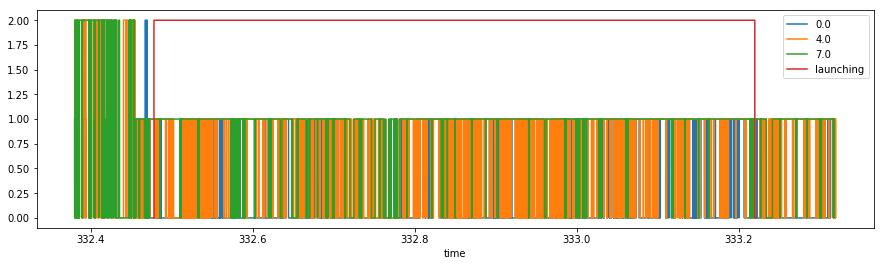

In [38]:
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

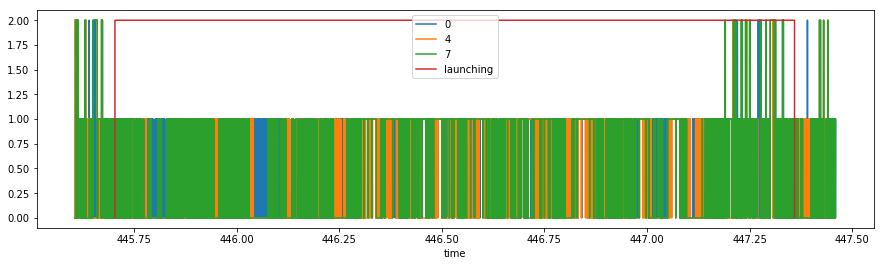

In [39]:
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [40]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [41]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
TEST_HH_systrace_BSP,lock_contention,0,5.857,10.647,0,22.914,0,42.352,0
TEST_HH_systrace_SEP,lock_contention,0,14.661,0.654,0,28.501,0,28.425,0
DIFF,lock_contention,0,-8.804,9.993,0,-5.587,0,13.927,0


In [42]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [43]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'TEST_HH_systrace_BSP'

,blocking,context,duration,effection,owner,pid,time,type
121,void com.android.server.wm.ActivityMetricsLog...,monitor contention with owner Binder:1238_4 (1...,16.422,O,Binder:1238_4 (1962) at void com.android.serve...,1238,148.714865,B
122,void com.android.server.wm.WindowSurfacePlace...,monitor contention with owner Binder:1238_4 (1...,11.811,O,Binder:1238_4 (1962) at void com.android.serve...,1238,148.719476,B
8,void com.android.server.wm.ActivityMetricsLog...,monitor contention with owner Binder:1238_C (2...,8.644,O,Binder:1238_C (2855) at void com.android.serve...,1238,147.839368,B
39,boolean com.android.server.wm.WindowProcessCo...,monitor contention with owner android.anim (13...,8.181,O,android.anim (1362) at void com.android.server...,2855,148.418371,B
55,void com.tune.TuneParameters.setAndroidId(jav...,monitor contention with owner main (4154) at b...,8.003,O,main (4154) at boolean android.os.BinderProxy....,4596,148.471040,B
44,boolean com.android.server.wm.WindowProcessCo...,monitor contention with owner android.anim (13...,7.118,O,android.anim (1362) at void com.android.server...,2855,148.430220,B
35,void com.android.server.wm.RemoteAnimationCon...,monitor contention with owner Binder:1238_5 (2...,6.756,O,Binder:1238_5 (2051) at int com.android.server...,2855,148.403036,B
9,com.android.server.policy.WindowManagerPolicy...,monitor contention with owner Binder:1238_C (2...,6.687,O,Binder:1238_C (2855) at void com.android.serve...,1238,147.841325,B
120,void com.google.android.gms.internal.azj.adE(...,monitor contention with owner pool-13-thread-1...,5.353,O,pool-13-thread-19 (4643) at java.lang.String c...,4154,148.675506,B
28,java.lang.CharSequence android.content.res.As...,monitor contention with owner main (4154) at l...,4.515,O,main (4154) at long android.content.res.ApkAss...,4154,147.993112,B


In [44]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'TEST_HH_systrace_SEP'

,blocking,context,duration,effection,owner,pid,time,type
118,java.util.ArrayList com.adobe.reader.filebrow...,monitor contention with owner pool-13-thread-1...,34.338,O,pool-13-thread-1 (10959) at void com.adobe.rea...,5173,446.623715,B
4,int com.android.server.wm.ActivityTaskManager...,monitor contention with owner Binder:1478_19 (...,30.764,O,Binder:1478_19 (8187) at void com.android.serv...,3437,445.751407,B
5,int com.android.server.wm.WindowManagerServic...,monitor contention with owner Binder:1478_19 (...,30.747,O,Binder:1478_19 (8187) at void com.android.serv...,1478,445.751576,B
6,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1478_C (3...,26.673,O,Binder:1478_C (3437) at android.app.ContentPro...,1478,445.755650,B
74,void com.android.server.wm.WindowAnimator.lam...,monitor contention with owner Binder:1478_6 (2...,20.452,O,Binder:1478_6 (2186) at void com.android.serve...,1478,446.123671,B
35,void com.android.server.wm.ActivityTaskManage...,monitor contention with owner android.anim (15...,7.933,O,android.anim (1549) at void com.android.server...,1478,445.877967,B
67,void com.android.server.wm.ActivityTaskManage...,monitor contention with owner Binder:1478_6 (2...,7.750,O,Binder:1478_6 (2186) at int com.android.server...,1478,446.102105,B
159,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1478_C (3...,5.904,O,Binder:1478_C (3437) at int com.android.server...,1478,447.645972,B
18,boolean com.android.server.wm.ActivityTaskMan...,monitor contention with owner android.anim (15...,5.802,O,android.anim (1549) at int com.android.server....,3437,445.796559,B
134,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1478_1 (1...,5.702,O,Binder:1478_1 (1494) at int com.android.server...,1478,447.188106,B


In [45]:
display(group1.title)
display(df1['duration'].sum())

u'TEST_HH_systrace_BSP'

167.11500000013757

In [46]:
display(group2.title)
display(df2['duration'].sum())

u'TEST_HH_systrace_SEP'

278.8760000000252

Sum of the lock contention's duration. The durations could be duplicated.

Liminated the lock contentions by owners.

In [47]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'TEST_HH_systrace_BSP'

,owner
pool-13-thread-19 (4643) at java.lang.String com.google.android.ads.zxxz.k.a(android.content.Context)(:-1),11
"main (4154) at void java.lang.Thread.nativeCreate(java.lang.Thread, long, boolean)(Thread.java:-2)",11
android.anim (1362) at void com.android.server.wm.WindowSurfacePlacer.lambda$new$0$WindowSurfacePlacer()(WindowSurfacePlacer.java:61),11
android.anim (1362) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),10
android.anim (1362) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:117),9
"pool-13-thread-10 (4634) at byte[] com.google.android.gms.internal.adr.d(byte[], java.lang.String)(:-1)",7
"Binder:1238_4 (1962) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:1986)",5
android.anim (1362) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:132),5
"pool-13-thread-1 (4616) at byte[] com.google.android.gms.internal.adr.d(byte[], java.lang.String)(:-1)",3
android.display (1361) at void com.android.server.wm.WindowManagerService$H.handleMessage(android.os.Message)(WindowManagerService.java:4896),3


In [48]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'TEST_HH_systrace_SEP'

,owner
android.anim (1549) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),12
android.anim (1549) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:126),11
android.anim (1549) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:132),10
"Binder:1478_C (3437) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2249)",7
android.anim (1549) at void com.android.server.wm.WindowSurfacePlacer.lambda$new$0$WindowSurfacePlacer()(WindowSurfacePlacer.java:65),6
"android.display (1547) at void com.android.server.wm.TaskChangeNotificationController.forAllRemoteListeners(com.android.server.wm.TaskChangeNotificationController$TaskStackConsumer, android.os.Message)(TaskChangeNotificationController.java:282)",5
"Binder:1478_15 (5857) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2249)",4
"Binder:1478_C (3437) at int com.android.server.pm.PackageManagerService.checkUidPermission(java.lang.String, int)(PackageManagerService.java:6662)",4
"Binder:1478_1 (1494) at void com.android.server.wm.ActivityTaskManagerService.setTaskDescription(android.os.IBinder, android.app.ActivityManager$TaskDescription)(ActivityTaskManagerService.java:3705)",3
"Binder:1478_19 (8187) at void com.android.server.wm.ActivityTaskManagerService.setTaskDescription(android.os.IBinder, android.app.ActivityManager$TaskDescription)(ActivityTaskManagerService.java:3705)",3


Text(0,0.5,'weight')

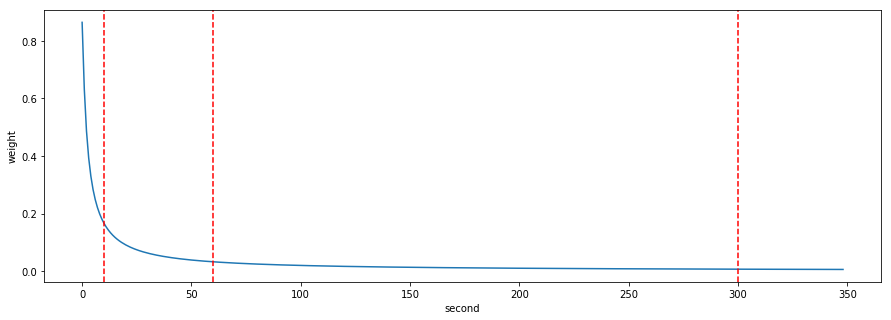

In [49]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')